In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

## Reading Training Dataset

In [35]:
train_data = pd.read_csv("train.csv")
train_data.shape

(42000, 785)

In [36]:
X = train_data.drop("label", axis=1)
y = train_data["label"]
print(f'Shape of X : {X.shape}')
print(f'Shape of y : {y.shape}')

Shape of X : (42000, 784)
Shape of y : (42000,)


## Normalization
the input data is set to be between 0 and 1

In [37]:
X = X / 255.0

## Splitting the Training Data
split the data into an 80% training set and a 20% validation set

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (33600, 784)
X_val shape: (8400, 784)
y_train shape: (33600,)
y_val shape: (8400,)


## Convert to PyTorch tensors

In [39]:
import torch

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

## Display some Samples of the input Data

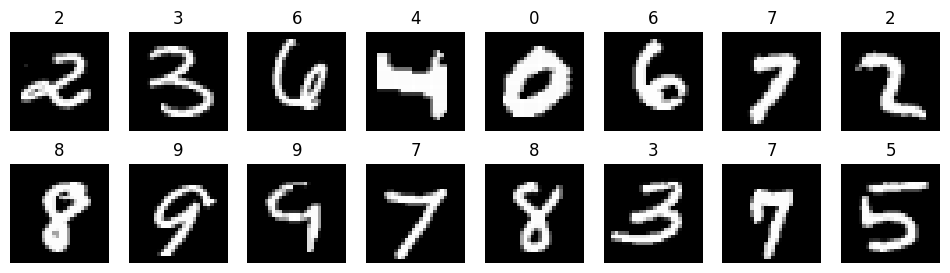

In [40]:
plt.figure(figsize = (12,10))

for i in range(16):
    plt.subplot(6,8,i+1)
    img = X_train_tensor[i].numpy()
    img = img.reshape((28,28))
    plt.imshow(img,cmap='gray')
    plt.title(str(y_train_tensor[i].item()))
    plt.axis("off")
plt.show()

## Constructing Our NeuralNetwork
- It consists of Four hidden layers.
- Using ReLU activation functions between hidden layers.
- Using softmax for the last layer to get the class with the highest probability.

In [41]:
from torch import nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)

        self.fc2 = nn.Linear(512, 256)
        
        self.fc3 = nn.Linear(256, 128)
        
        self.fc4 = nn.Linear(128, 10)        # 10 output classes for digits 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

## Function to calculate the Training losses and accuracies for each Epoch
- Training our model and updating weights & bias using backpropagation.
- Saving all the results for the loss and accuracy.

In [42]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader: 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        val_accuracy = total_correct / total_samples
        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    return train_losses, train_accuracies, val_losses , val_accuracies

## Function to plot the results

In [43]:
def plot_accuracy_loss(result, figure_size = (12 , 4)):
    lr = result['lr']
    bs = result['bs']
    train_losses = result['train_losses']
    train_accuracies = result['train_accuracies']
    val_losses = result['val_losses']
    val_accuracies = result['val_accuracies']

    # Plotting
    plt.figure(figsize=figure_size)

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses,marker = 'o', label=f'Training Loss (lr={lr}, bs={bs})')
    plt.plot(val_losses,marker = 'o', label=f'Validation Loss (lr={lr}, bs={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies,marker = 'o', label=f'Training Accuracy (lr={lr}, bs={bs})')
    plt.plot(val_accuracies,marker = 'o', label=f'Validation Accuracy (lr={lr}, bs={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [44]:
model = NeuralNetwork()
model

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Creating our loss function

In [45]:
cross_entropy_loss = nn.CrossEntropyLoss()

## Creating Our Dataset
- To use it in dataloader to load our data

In [46]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

## Getting best results
- Getting all results and best learning rate and batch size

In [47]:
from torch.utils.data import DataLoader 
from torch import optim


best_model = model
best_accuracy = 0.0
best_lr = 0.0
best_bs = 0
num_of_epochs = 10
results = []
best_result = None
learning_rates = [0.01, 0.03, 0.1, 0.3, 0.5]
batch_sizes = [16, 32, 64, 128, 256]

for lr in learning_rates:
    for bs in batch_sizes:
        print(f'For Learning rate = {lr} and Batch size = {bs}')
        # Set up model, optimizer, loaders
        model = NeuralNetwork()
        stochastic_GD = optim.SGD(model.parameters(), lr=lr)
        train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=bs, shuffle=False)

        train_losses, train_accuracies, val_losses , val_accuracies = train_model(model, train_loader, val_loader, cross_entropy_loss, optimizer=stochastic_GD, num_epochs=num_of_epochs)

        result = {
            'lr': lr,
            'bs': bs,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
        
        results.append(result)
        
        print("---------------------------------------------------------------------------------------------")
        if val_accuracies[num_of_epochs-1] >= best_accuracy:
            best_accuracy = val_accuracies[num_of_epochs-1]
            best_lr = lr
            best_bs = bs
            best_result = result
            best_model = model
    print("*********************************************************************************************")
    
print(f'Best Learning Rate: {best_lr}, Best Batch Size: {best_bs}, Best Accuracy: {best_accuracy:.4f}')

For Learning rate = 0.01 and Batch size = 16
Epoch 1/10, Train Loss: 2.3018, Train Accuracy: 0.2236, Val Loss: 2.3007, Val Accuracy: 0.3155
Epoch 2/10, Train Loss: 2.2989, Train Accuracy: 0.3168, Val Loss: 2.2963, Val Accuracy: 0.3075
Epoch 3/10, Train Loss: 2.2859, Train Accuracy: 0.2633, Val Loss: 2.2492, Val Accuracy: 0.2163
Epoch 4/10, Train Loss: 2.1525, Train Accuracy: 0.3090, Val Loss: 2.0333, Val Accuracy: 0.4098
Epoch 5/10, Train Loss: 1.9018, Train Accuracy: 0.6065, Val Loss: 1.7911, Val Accuracy: 0.7155
Epoch 6/10, Train Loss: 1.7579, Train Accuracy: 0.7284, Val Loss: 1.7373, Val Accuracy: 0.7388
Epoch 7/10, Train Loss: 1.7285, Train Accuracy: 0.7424, Val Loss: 1.7202, Val Accuracy: 0.7506
Epoch 8/10, Train Loss: 1.7157, Train Accuracy: 0.7516, Val Loss: 1.6707, Val Accuracy: 0.8080
Epoch 9/10, Train Loss: 1.6573, Train Accuracy: 0.8178, Val Loss: 1.6480, Val Accuracy: 0.8254
Epoch 10/10, Train Loss: 1.6426, Train Accuracy: 0.8281, Val Loss: 1.6392, Val Accuracy: 0.8306
----

## Best Result having the highest accuracy 

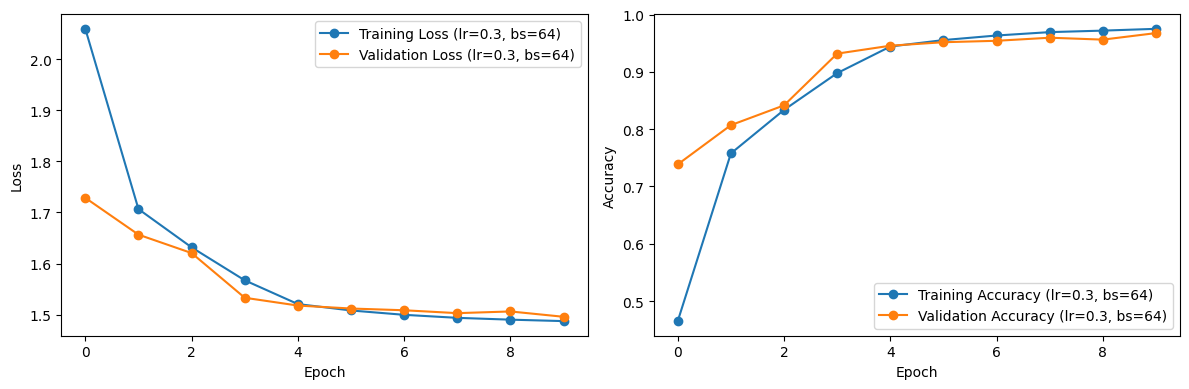

In [48]:
plot_accuracy_loss(best_result)

## plotting different learning rate for a fixed batch size
- when we increase the learning rate the accuracy reaches higher values (small learning rates need more epochs).
- when we increase the learning rate the loss reaches lower values.

In [49]:
differnt_lr = []

for lr in learning_rates:
    if lr == best_lr:
        differnt_lr.append(best_result)
        continue
    lr_results = [result for result in results if result['lr'] == lr and result['bs'] == best_bs]
    differnt_lr.extend(lr_results)                                                                                                                                            

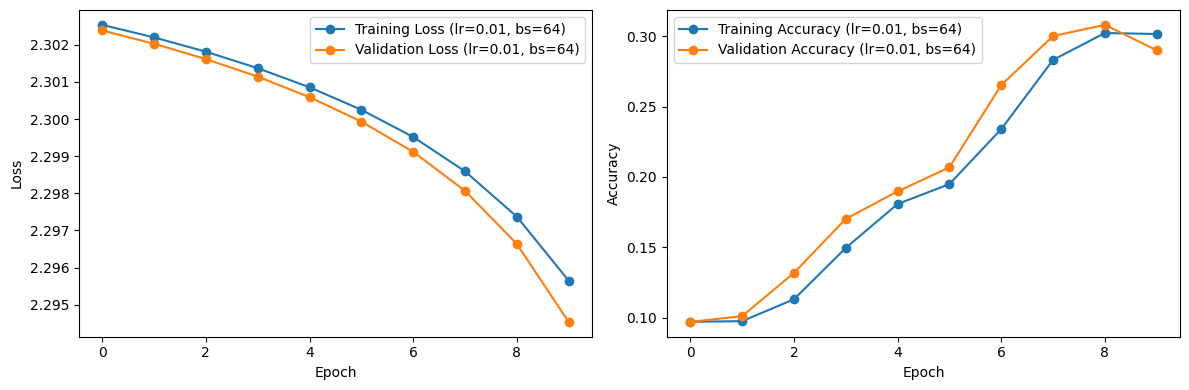

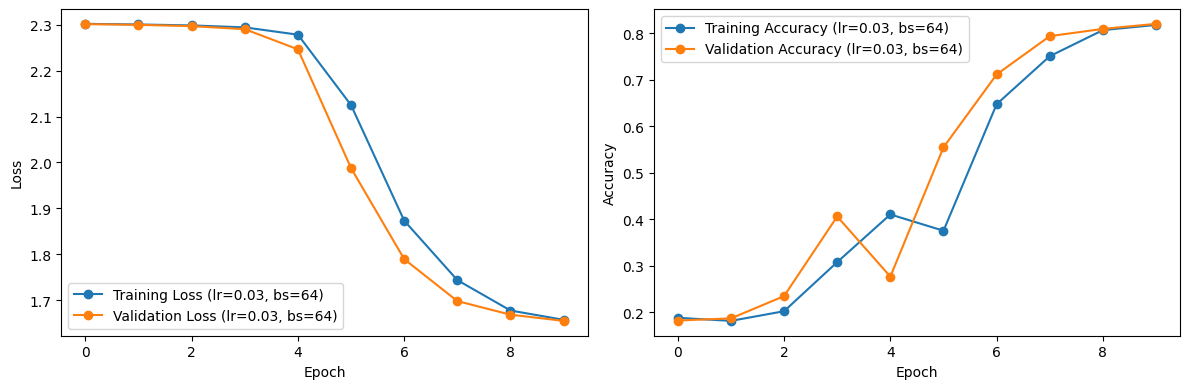

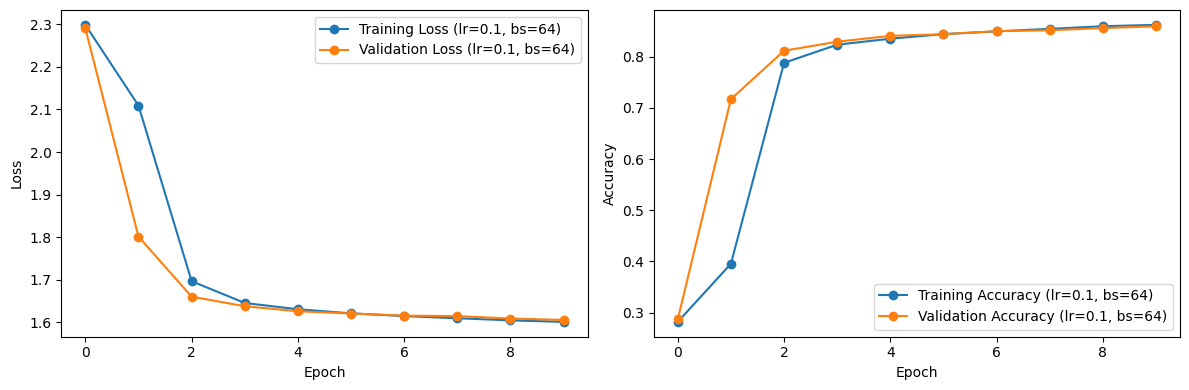

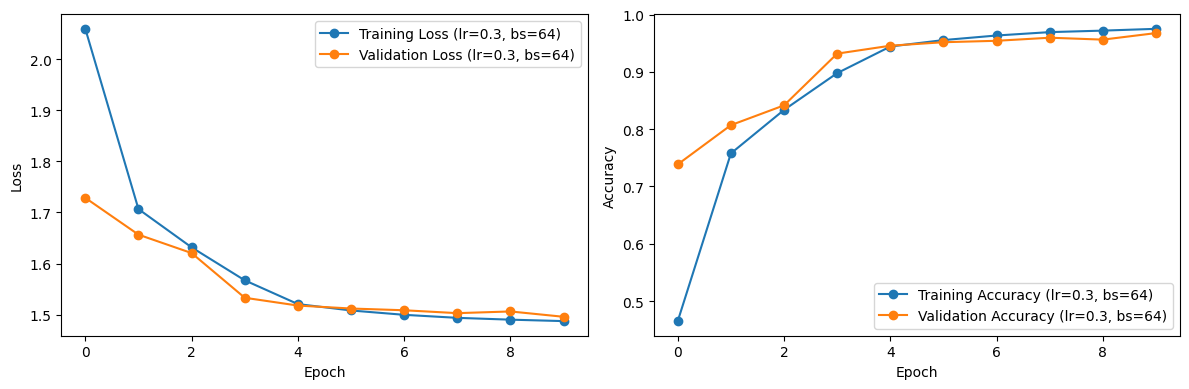

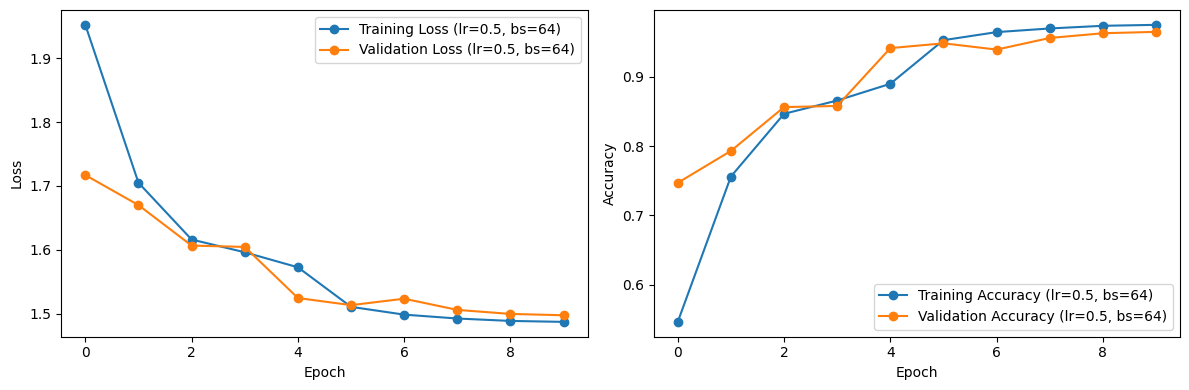

In [50]:
for result in differnt_lr: 
    plot_accuracy_loss(result)

## plotting different batch size rate for a fixed learning rate
- when we increase the batch size the loss increase 
- when we increase the batch size the maximum accuracy decrease 

In [51]:
differnt_bs = []

for bs in batch_sizes:
    if bs == best_bs:
        differnt_bs.append(best_result)
        continue
    bs_results = [result for result in results if result['lr'] == best_lr and result['bs'] == bs]
    differnt_bs.extend(bs_results) 

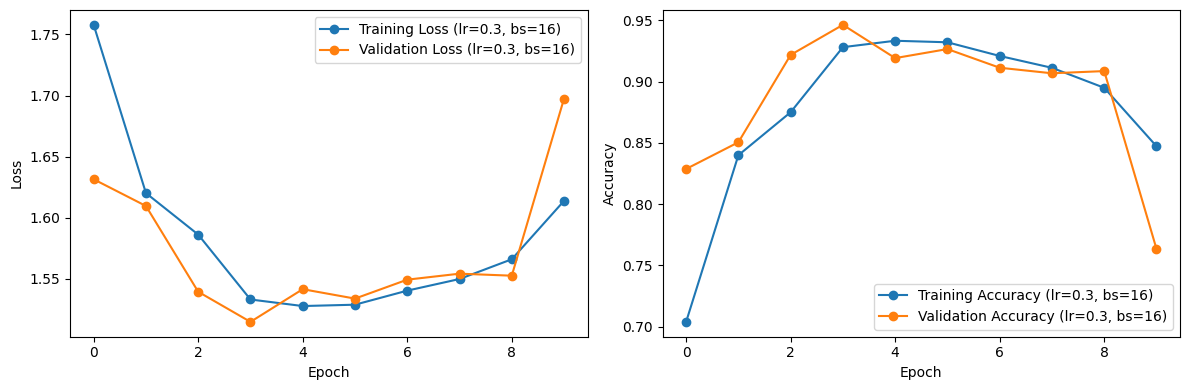

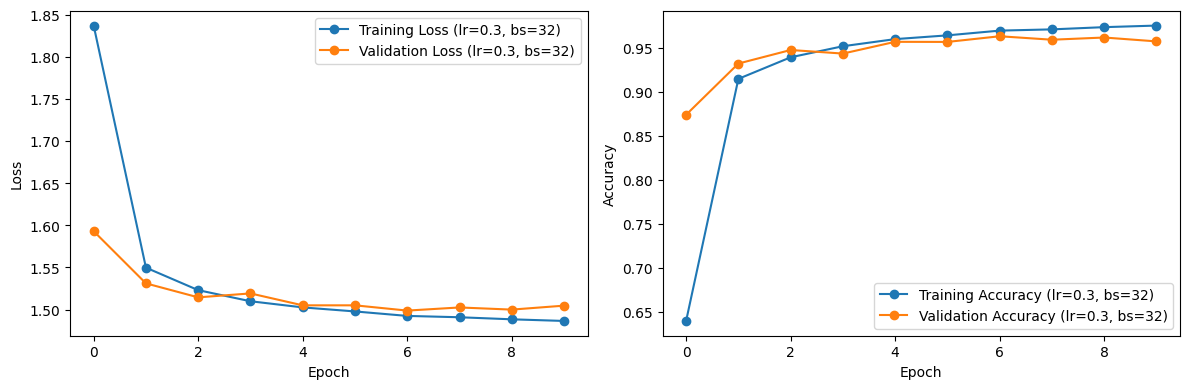

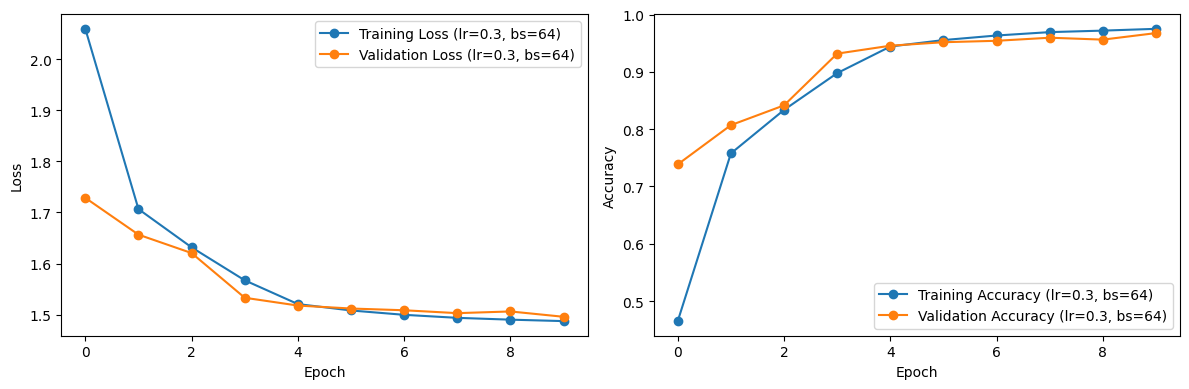

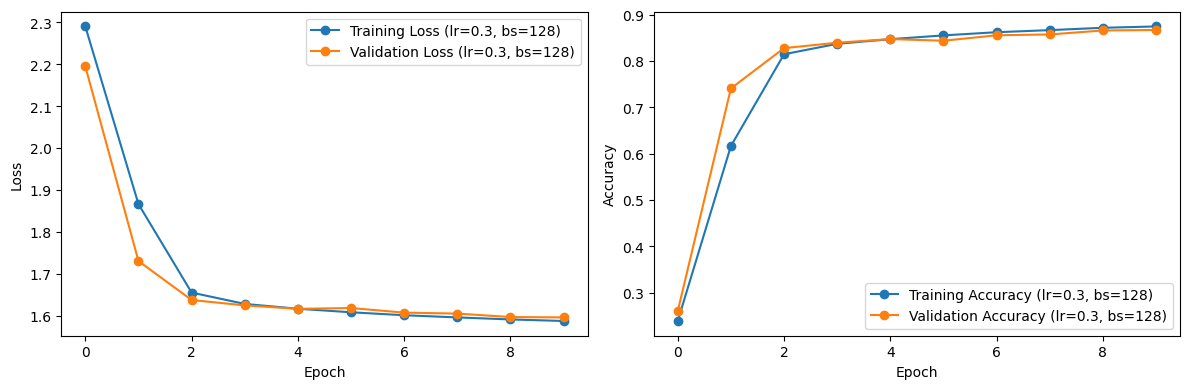

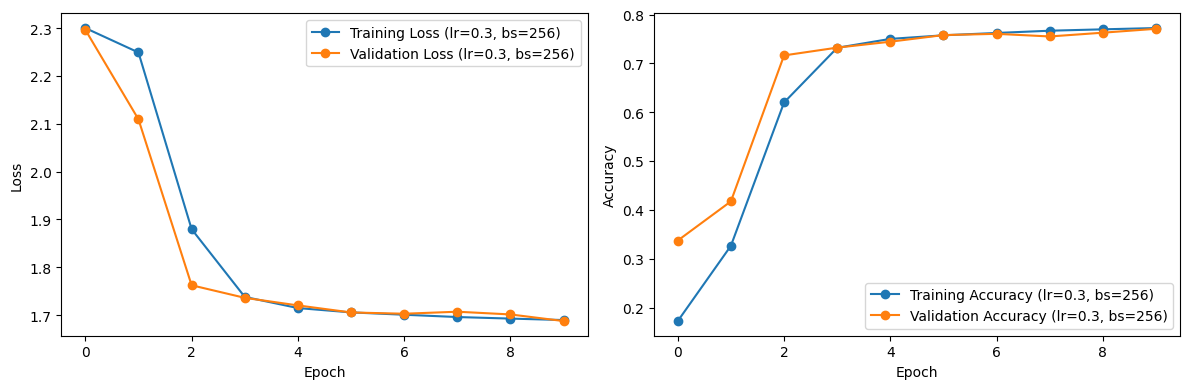

In [52]:
for result in differnt_bs: 
    plot_accuracy_loss(result)

## Improved NeuralNetwork
- It consists of Four hidden layers.
- Using ReLU activation functions between hidden layers.
- Using softmax for the last layer to get the class with the highest probability.
- Each hidden layer is followed by a normalizer to normalize the output of each layer.

In [53]:
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ImprovedNeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 512)
        self.norm1 = nn.LayerNorm(512)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(512, 256)
        self.norm2 = nn.LayerNorm(256)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(256, 128)
        self.norm3 = nn.LayerNorm(128)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(128, 10)
        self.norm4 = nn.LayerNorm(10)

    def forward(self, x):
        x = F.relu(self.norm1(self.dropout1(self.fc1(x))))
        x = F.relu(self.norm2(self.dropout2(self.fc2(x))))
        x = F.relu(self.norm3(self.dropout3(self.fc3(x))))
        x = F.softmax(self.norm4(self.fc4(x)),dim=1)
        return x


In [54]:
improved_model = ImprovedNeuralNetwork()
improved_model

ImprovedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (norm4): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
)

## Getting best results for the improved Neural Network
- Getting all results and best learning rate and batch size after improving the neural network

In [55]:
best_improved_model = improved_model
best_accuracy_new = 0.0
best_lr_new = 0.0
best_bs_new = 0
num_of_epochs = 10
results_new = []
best_result_new = None
learning_rates = [0.01, 0.03, 0.1, 0.3, 0.5]
batch_sizes = [16, 32, 64, 128, 256]

for lr in learning_rates:
    for bs in batch_sizes:
        print(f'For Learning rate = {lr} and Batch size = {bs}')
        # Set up model, optimizer, loaders
        model = ImprovedNeuralNetwork()
        stochastic_GD = optim.SGD(model.parameters(), lr=lr)
        train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=bs, shuffle=False)

        train_losses, train_accuracies, val_losses , val_accuracies = train_model(model, train_loader, val_loader, cross_entropy_loss, optimizer=stochastic_GD, num_epochs=num_of_epochs)

        result = {
            'lr': lr,
            'bs': bs,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
        
        results_new.append(result)
        
        print("---------------------------------------------------------------------------------------------")
        if val_accuracies[num_of_epochs-1] >= best_accuracy_new:
            best_accuracy_new = val_accuracies[num_of_epochs-1]
            best_lr_new = lr
            best_bs_new = bs
            best_result_new = result
            best_improved_model = model
    print("*********************************************************************************************")
    
print(f'Best Learning Rate: {best_lr_new}, Best Batch Size: {best_bs_new}, Best Accuracy: {best_accuracy_new:.4f}')

For Learning rate = 0.01 and Batch size = 16
Epoch 1/10, Train Loss: 1.7629, Train Accuracy: 0.8304, Val Loss: 1.5924, Val Accuracy: 0.9271
Epoch 2/10, Train Loss: 1.5762, Train Accuracy: 0.9323, Val Loss: 1.5484, Val Accuracy: 0.9399
Epoch 3/10, Train Loss: 1.5415, Train Accuracy: 0.9466, Val Loss: 1.5258, Val Accuracy: 0.9519
Epoch 4/10, Train Loss: 1.5251, Train Accuracy: 0.9553, Val Loss: 1.5184, Val Accuracy: 0.9557
Epoch 5/10, Train Loss: 1.5151, Train Accuracy: 0.9610, Val Loss: 1.5178, Val Accuracy: 0.9526
Epoch 6/10, Train Loss: 1.5092, Train Accuracy: 0.9640, Val Loss: 1.5085, Val Accuracy: 0.9627
Epoch 7/10, Train Loss: 1.5026, Train Accuracy: 0.9688, Val Loss: 1.5050, Val Accuracy: 0.9627
Epoch 8/10, Train Loss: 1.5008, Train Accuracy: 0.9698, Val Loss: 1.5042, Val Accuracy: 0.9643
Epoch 9/10, Train Loss: 1.4973, Train Accuracy: 0.9719, Val Loss: 1.5029, Val Accuracy: 0.9638
Epoch 10/10, Train Loss: 1.4936, Train Accuracy: 0.9746, Val Loss: 1.4998, Val Accuracy: 0.9669
----

## Analysis of the Results
- in the improved neural network we reached the higher accuracy faster than the previous neural network.

In [56]:
differnt_lr_new = []

for lr in learning_rates:
    if lr == best_lr_new:
        differnt_lr.append(best_result_new)
        continue
    lr_results = [result for result in results_new if result['lr'] == lr and result['bs'] == best_bs_new]
    differnt_lr_new.extend(lr_results)          

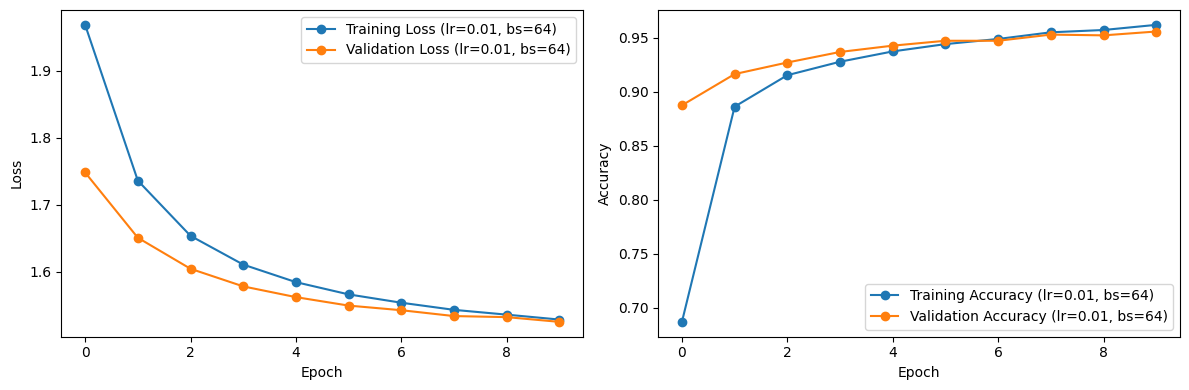

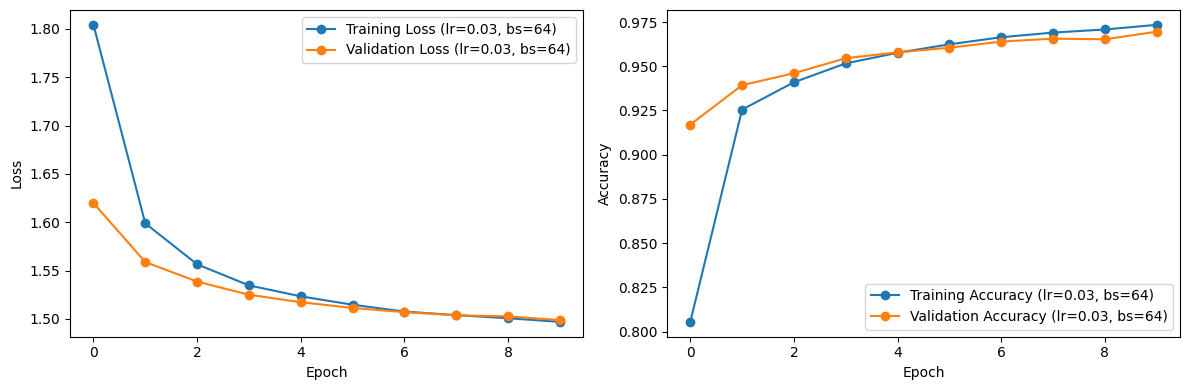

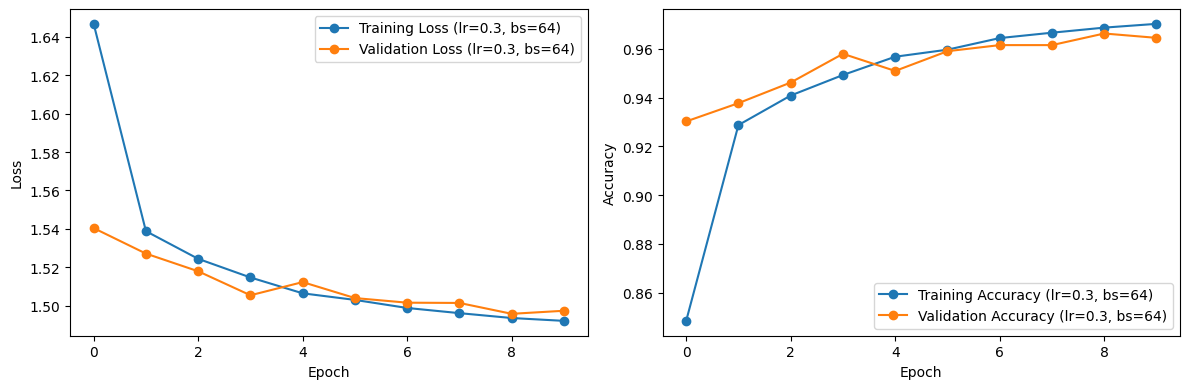

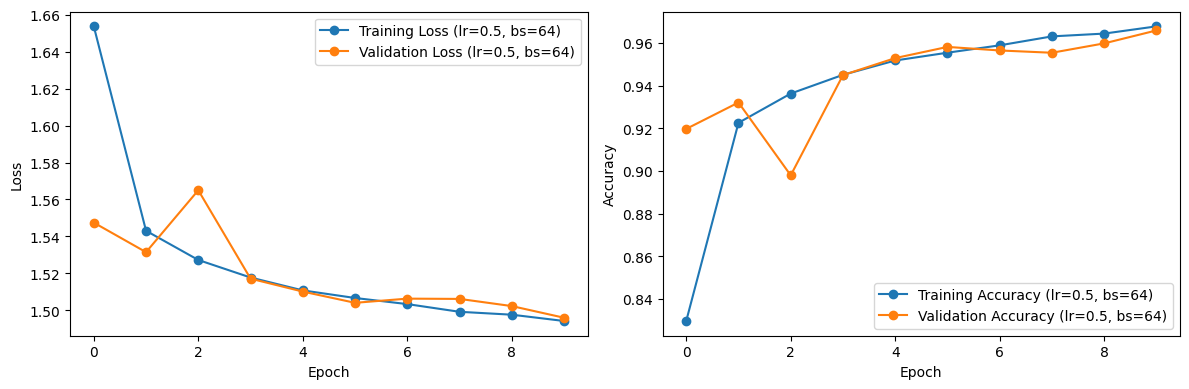

In [57]:
for result in differnt_lr_new: 
    plot_accuracy_loss(result)

In [58]:
differnt_bs_new = []

for bs in batch_sizes:
    if bs == best_bs_new:
        differnt_bs.append(best_result_new)
        continue
    bs_results = [result for result in results_new if result['lr'] == best_lr_new and result['bs'] == bs]
    differnt_bs_new.extend(bs_results) 

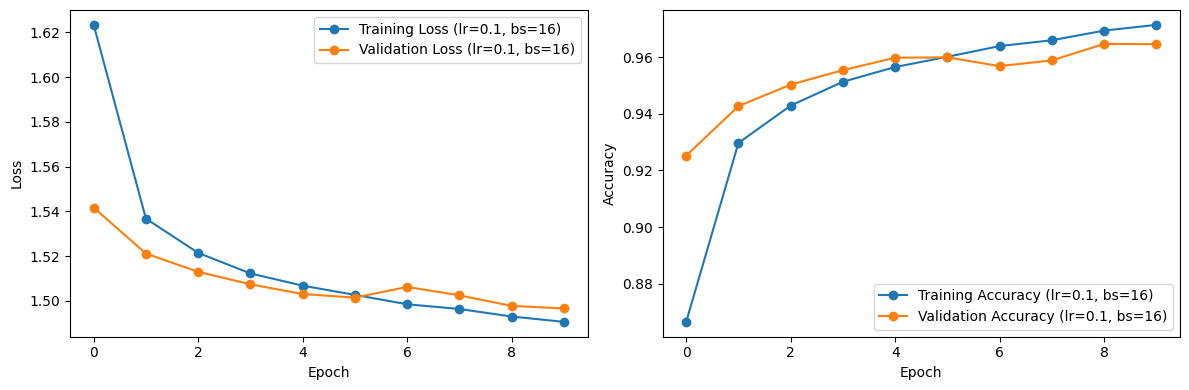

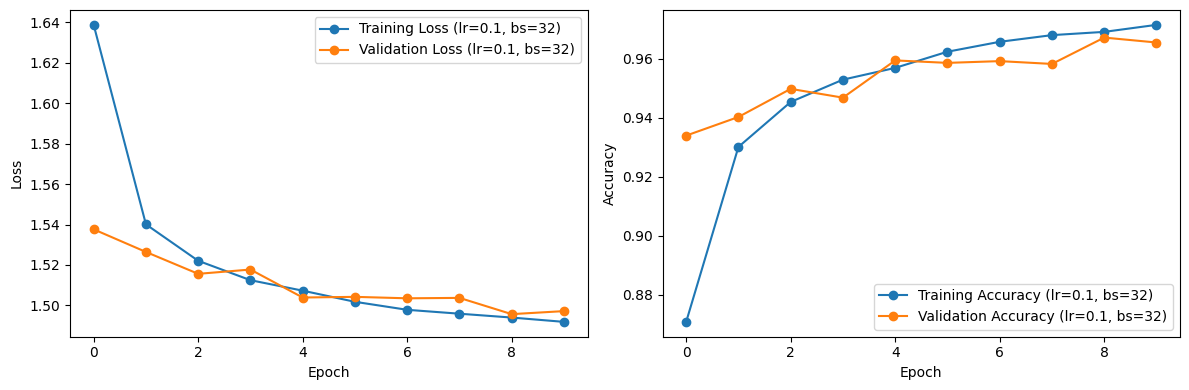

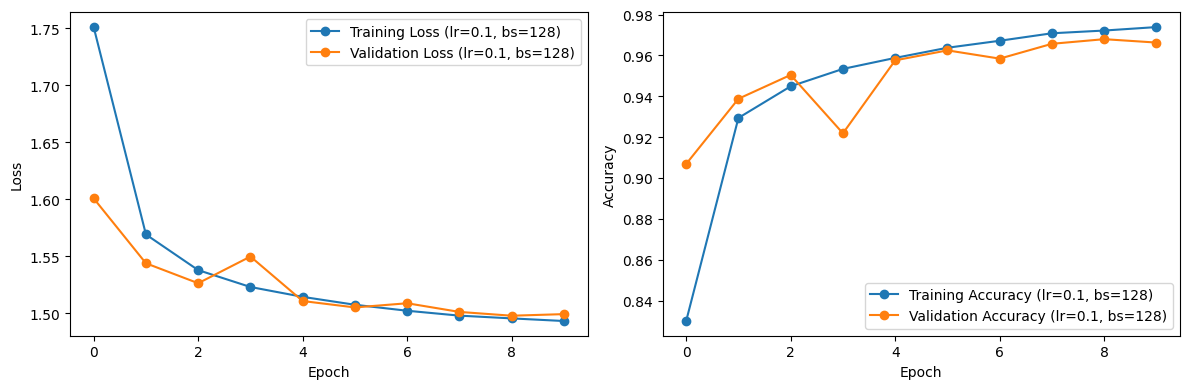

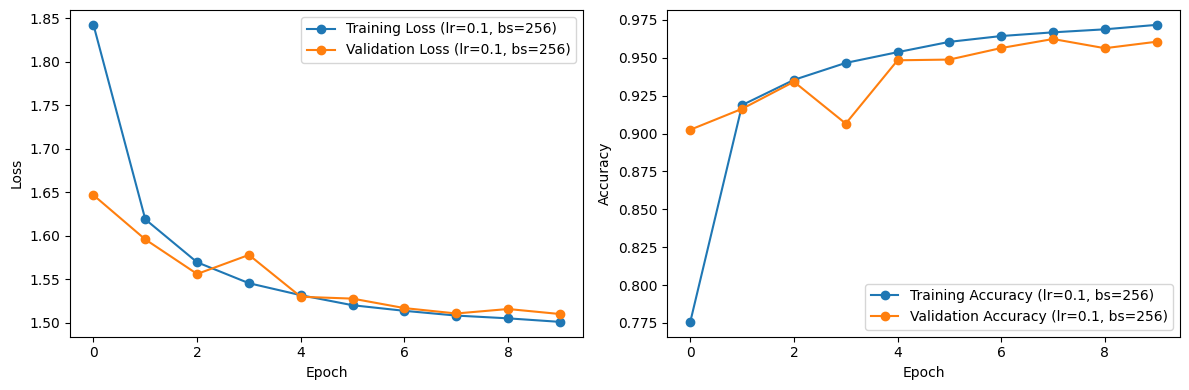

In [59]:
for result in differnt_bs_new: 
    plot_accuracy_loss(result)

## Testing our model

In [60]:
test_data = pd.read_csv("test.csv")

X_test = train_data.drop("label", axis=1)
y_test = train_data["label"]
print(f'Shape of X : {X_test.shape}')
print(f'Shape of y : {y_test.shape}')

X_test = X_test / 255.0

Shape of X : (42000, 784)
Shape of y : (42000,)


### Converting testing data to Pytorch tensors

In [61]:
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [62]:
test_dataset = TensorDataset(X_test, y_test)

### Loading the data set of best batch size to be tested

In [63]:
# for simple model
test_loader_simple = DataLoader(dataset=test_dataset, batch_size=best_bs, shuffle=False)

# for improved model
test_loader_improved = DataLoader(dataset=test_dataset, batch_size=best_bs_new, shuffle=False)

### Function evaluates the accuracy of the given neural network model on the test dataset 

In [64]:
def calculate_test_accuracy(model, test_loader):
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    return accuracy

In [65]:

test_accuracy_best_model = calculate_test_accuracy(best_model, test_loader_simple)
print(f'Test Accuracy (best_model): {test_accuracy_best_model * 100:.2f} %')

test_accuracy_best_improved_model = calculate_test_accuracy(best_improved_model, test_loader_improved)
print(f'Test Accuracy (best_improved_model): {test_accuracy_best_improved_model * 100:.2f} %')

Test Accuracy (best_model): 97.77 %
Test Accuracy (best_improved_model): 98.01 %


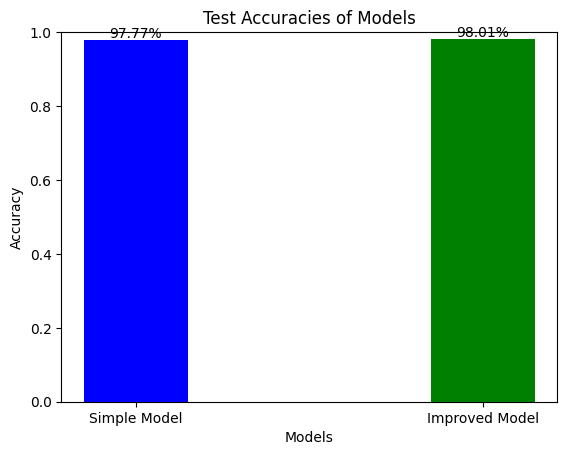

In [72]:
# Test accuracies
accuracies = [test_accuracy_best_model, test_accuracy_best_improved_model]
models = ['Simple Model', 'Improved Model']

# Plotting the bar chart
fig, ax = plt.subplots()
bars = plt.bar(models, accuracies, color=['blue', 'green'],width=0.3)
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1 (assuming accuracy is between 0 and 1)
plt.title('Test Accuracies of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Adding text annotations
for bar, accuracy in zip(bars, accuracies):
    yval = accuracy
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval*100:.2f}%', ha='center', va='bottom')

plt.show()
